In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy as d_copy
import random
import gc

print(torch.__version__, torchvision.__version__)
print(torch.cuda.get_device_name(0))

1.8.0 0.2.2
GeForce RTX 3080


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#error_index = 0
vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)#.to(device)
print(device)

cuda


In [3]:
# randomness 제어 
# https://hoya012.github.io/blog/reproducible_pytorch/
def set_randomness(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
# func

# only apply for feature part (not pooling, classfier)
# because of layers.feature 
def split_layer(model,start,end):
    ct = 0
    split_model=[] # from start to Conv5_1(include ReLU)
    for name,layers in model.named_modules():
        #print(name,layer)
        #print(layers.features)
        for idx,layer in enumerate(layers.features):
            #print(idx,layer)
            if start <=idx and idx <=end :
                split_model.append(layer)
        break
    return nn.Sequential(*split_model)

def error_injection(name,num_error,start_index):
    def hook(model,input):
        start = start_index
        end = start_index + num_error
        input[0][:, start:end]=0
        print("shape :",input[0][:, start:end].size())
    return hook
'''
def hook_register(model,error_index,num_error):
    param_list = []
    handle =[]
    for name,parameter in model.named_parameters():
        if "features.34.weight" in name:
        #print(name,"size:",parameter.size())
            param_list.append(parameter)
    for name,layer in model.named_modules():
    #print(name)
        if "34" in name  and isinstance(layer, torch.nn.modules.conv.Conv2d):
            print("input",name,layer) # target layer Conv5_1
            tmp = layer.register_forward_pre_hook(error_injection(name,num_error,error_index))
            handle.append(tmp)
        if "36" in name :
            print("output",name,layer)
            tmp = layer.register_forward_pre_hook(name)
            handle.append(tmp)
    return param_list,handle
'''

'\ndef hook_register(model,error_index,num_error):\n    param_list = []\n    handle =[]\n    for name,parameter in model.named_parameters():\n        if "features.34.weight" in name:\n        #print(name,"size:",parameter.size())\n            param_list.append(parameter)\n    for name,layer in model.named_modules():\n    #print(name)\n        if "34" in name  and isinstance(layer, torch.nn.modules.conv.Conv2d):\n            print("input",name,layer) # target layer Conv5_1\n            tmp = layer.register_forward_pre_hook(error_injection(name,num_error,error_index))\n            handle.append(tmp)\n        if "36" in name :\n            print("output",name,layer)\n            tmp = layer.register_forward_pre_hook(name)\n            handle.append(tmp)\n    return param_list,handle\n'

In [4]:
!ls /media/0/hwbae0326/F4F

0624_models		      kdw_F4F.ipynb
0624_to_34models	      make_F4F_keras.ipynb
0624_to_34models_petImage     make_F4F_pytorch.ipynb
acc_log_to34.txt	      make_F4F_pytorch-to34.ipynb
acc_log.txt		      models
autoencoder_model.ipynb       model_test
F4F_addDense.py		      output.txt
F4F_keras.ipynb		      README.md
F4F_pytorch.ipynb	      tmp.txt
Filter_for_Filter_result.txt  trythis.ipynb
find_corelation


In [5]:
# dataset load
batch_size = 16 # 32~ out of memory in 3080
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset_path = "/media/0/hwbae0326/PetImages"
retrain_model_path = "/media/0/hwbae0326/F4F/0624_to_34models_petImage/"
# imagenet data load
train_dataset = dataset.ImageFolder(root=dataset_path,
                                       transform=transform)
train_dataset,val_dataset = torch.utils.data.random_split(train_dataset, [20000,4998])


train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=4) # for using subset
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=4) # for using subset

print(len(train_dataloader))
gc.collect()

1250


0

In [6]:
if os.path.isdir(retrain_model_path) is False:
    os.mkdir(retrain_model_path)

In [7]:
seed = 0
set_randomness(seed)

In [8]:
# external variable in error_index, num_error

def make_error_info(error_index, num_error):
    data = []
    for i in range(511,-1,-1):
        if error_index <= i and i < error_index+num_error:
            data.append(1)
        else :
            data.append(0)
        #print(data)
    error_info = torch.Tensor(data)
    error_info  = error_info.unsqueeze(0).repeat(512,1)
        #print(error_info)
    return error_info # 512,521
class F4F(nn.Module):
    def __init__(self):
        super().__init__()
        self.f4f = nn.Linear(3*3*512+512,3*3*512) # 4167,4608 filter which change feature.34 (Conv5_1)
        # 512 x5120 사이즈로 batch 저장
        #print(type(self.f4f.weight))
        self.f4f_optimizer =  torch.optim.SGD([self.f4f.weight],lr=0.0005,weight_decay=1e-4)
    def get_f4f_weight(self):
        # fc.weight.size(),fc.bias.size()
        return self.f4f.weight # torch.Size([4608, 5120])
    def forward(self,x):
        x = self.f4f(x)
        y = torch.tanh(x)
        return y
        

In [9]:
class Target_model(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model = model
    def get_layer(self,idx):
        #print(self.model._modules['34'])
        return self.model._modules[str(idx)]
    def apply_f4f(self,f4f,error_info):
            #print(len(self.get_layer(34).weight.data))
            #print(self.get_layer(34).weight.data.size())
        weight = torch.reshape(self.get_layer(34).weight.data,(512,512*3*3)).to(device) # flatten [512,5210] (batch 512)
            #print(weight.size(),error_info.size())
        data = torch.cat( (weight,error_info), 1 )
            #print(data.size())
        offset = torch.reshape(f4f(data),(512,512,3,3))
        offset = torch.tanh(offset)
        self.get_layer(34).weight.data = self.get_layer(34).weight.data + offset
            #break # for debug
    def forward(self,x,f4f,error_info):
        # apply_f4f는 매 epoch마다 동일하므로 
        self.apply_f4f(f4f,error_info)
        y = self.model(x)
        return y
class Test_model(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model = model
    def get_layer(self,idx):
        return self.model.features._modules[str(idx)]
    def apply_f4f(self,f4f,error_info):
        weight = torch.reshape(self.get_layer(34).weight.data,(512,512*3*3)).to(device) # flatten [512,5210] (batch 512)
        data = torch.cat( (weight,error_info), 1 )
        offset = torch.reshape(f4f(data),(512,512,3,3))
        offset = torch.tanh(offset)
        self.get_layer(34).weight.data = self.get_layer(34).weight.data + offset
            #break # for debug
    def forward(self,x,f4f,error_info):
        # apply_f4f는 매 epoch마다 동일하므로 
        self.apply_f4f(f4f,error_info)
        y = self.model(x)
        return y

In [10]:
In_layer_number = 34 # 34 conv5_1 convolution
Out_layer_number = 36 # 36 conv5_1 relu 
error_index=0
max_epochs = 30
num_error = 128
#optimizer = torch.optim.SGD(param_list,lr=0.01,weight_decay=1e-4)

In [11]:
def hook_register(model,error_index,num_error):
    for name,layer in model.named_modules():
        #print(name,layer)
        if "34" in name  and isinstance(layer, torch.nn.modules.conv.Conv2d):
            print("input",name,layer) # target layer Conv5_1
            layer.register_forward_pre_hook(error_injection(name,num_error,error_index))
        break

In [12]:
split_model = split_layer(vgg16_bn,0,34)
#print(split_model)
original_model = d_copy(split_model).to(device)
#param_list,handle = hook_register(split_model,error_index,num_error)

hook_register(split_model,error_index,num_error)
target_model = Target_model(split_model).to(device)
target_model.get_layer(In_layer_number)


test = d_copy(vgg16_bn).to(device)
hook_register(test,error_index,num_error)
test_model = Test_model(test).to(device)

log_file = "./acc_log_petimage.txt"

In [13]:
# evaluation phasetraining
def eval(model,dataloader,epoch,f4f,error_info):

    model.cuda()
    model.eval()
    total = 0
    correct =0
    with torch.no_grad():
        print("======eval start=======")
        for i, data in enumerate(dataloader):
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)
        
            y_hat = model(inputs,f4f,error_info)
            _, predicted = torch.max(y_hat.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if(i%200 == 199):
                print("step : %d / %d acc : %.3f"
                      %(i + 1,int(len(dataloader)/labels.size(0)), correct*100/total))
                #print(".",end="")
        print("")
    acc = 100*correct/total
    print("%dth epoch acc of %s on imagenet : %.4f %%" %(epoch, model.__class__.__name__,acc)) 
    f = open(log_file,"a")
    print("%dth epoch acc of %s on imagenet : %.4f %%" %(epoch, model.__class__.__name__,acc),file=f) 
    f.close()
    print("======eval  end ======")  
    return acc
#torch.save(vgg16_bn.state_dict(), retrain_model_path+"test_vgg16_bn_state_dict.pt")
def model_copy(model):
    return deepcopy(model.state_dict())

In [ ]:
# training
def training(test_model,target_model,original_model,train_dataloader,test_dataloader,loss_fn,error_idx,num_error,max_epochs=30,subset=False):
    f4f = F4F().to(device)
    target_model.to(device)
    original_model.to(device)
    error_info = make_error_info(error_index,num_error).to(device)
    first_feature = []
    original = []
    optimizer = f4f.f4f_optimizer
    for epoch in range(max_epochs):
        running_loss = 0.0
        total_avg_loss = 0.0
        print("=====epoch %d start======"%(epoch+1))
        f4f.train()
        # update f4f filter
        #target_model.apply_f4f(f4f,error_info)
    
        # compare
        for i, data in enumerate(train_dataloader):
            print(".",end="")
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)
            
            original_out = original_model(inputs)
            target_out = target_model(inputs,f4f,error_info)
            if i == 0:
                first_feature.append(target_out[0])
                original.append(original_out[0])
                
            loss = loss_fn(original_out,target_out)
            #print(loss.size())
            running_loss += loss.item()
            target_model.model.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 99: 
                total_avg_loss += running_loss
                print("")
                print('[%d, %5d] loss: %.6f' % (epoch+1, i+1, running_loss/100)) 
                running_loss = 0.0
        # save weight
        total_avg_loss /= len(train_dataloader)
        acc = eval(test_model,test_dataloader,epoch,f4f,error_info)
        
        torch.save(f4f.get_f4f_weight(), 
               retrain_model_path+"%s~%s_pkt_err_f4f_epoch_%s_acc_%s_loss_%.6f.pt"
               %(str(error_idx).zfill(3),str(error_idx+num_error).zfill(3),
                str(epoch+1).zfill(2),str(acc+1).zfill(3),total_avg_loss))    
    return original_out,first_feature
                

In [15]:
loss_fn = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.SGD(param_list,lr=0.01,weight_decay=1e-4)
first_feature = []
original_out = []
f = open(log_file,"w")
f.close()
for error_idx in range(0,512,num_error):
    print("**********error_idx :%d, num error :%d**********"%(error_idx, num_error))
    f = open(log_file,"a")
    print("**********error_idx :%d, num error :%d**********"%(error_idx, num_error),file=f)
    f.close()
    split_model = split_layer(vgg16_bn,0,34)
    #original_model = d_copy(split_model).to(device)
    hook_register(split_model,error_index,num_error)
    target_model = Target_model(split_model).to(device)
    
    tmp= training(test_model,target_model,original_model,train_dataloader,val_dataloader,loss_fn,error_idx,num_error,10,True)
    first_feature.append(tmp[1])
    original_out.append(tmp[0])

**********error_idx :0, num error :128**********
=====epoch 1 start======
.................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


...................................
[1,   100] loss: 50608.017664
....................................................................................................
[1,   200] loss: 432274.357812
....................................................................................................
[1,   300] loss: 1232512.449375
....................................................................................................
[1,   400] loss: 2428459.116250
....................................................................................................
[1,   500] loss: 4049199.127500
....................................................................................................
[1,   600] loss: 6050181.645000
....................................................................................................
[1,   700] loss: 8371600.315000
....................................................................................................
[1,   800] loss: 11094546.420000
...

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.........................................................
[2,   300] loss: 44585494.520000
....................................................................................................
[2,   400] loss: 50458562.440000
....................................................................................................
[2,   500] loss: 57464762.840000
....................................................................................................
[2,   600] loss: 63930620.040000
....................................................................................................
[2,   700] loss: 71467046.840000
....................................................................................................
[2,   800] loss: 78944150.240000
....................................................................................................
[2,   900] loss: 87067920.720000
....................................................................................................
[2, 

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.......................................................
[3,   500] loss: 172906883.360000
....................................................................................................
[3,   600] loss: 185216876.960000
....................................................................................................
[3,   700] loss: 198368106.400000
....................................................................................................
[3,   800] loss: 210750912.000000
....................................................................................................
[3,   900] loss: 223448050.880000
....................................................................................................
[3,  1000] loss: 236273350.400000
....................................................................................................
[3,  1100] loss: 251839217.280000
....................................................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.............................................
[4,   600] loss: 372051720.640000
....................................................................................................
[4,   700] loss: 388487821.760000
....................................................................................................
[4,   800] loss: 408198392.640000
....................................................................................................
[4,   900] loss: 425536466.880000
....................................................................................................
[4,  1000] loss: 447499588.800000
....................................................................................................
[4,  1100] loss: 465548433.600000
....................................................................................................
[4,  1200] loss: 483340007.680000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

3th epo

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


......................................................................
[5,  1100] loss: 745879212.160000
....................................................................................................
[5,  1200] loss: 771918353.920000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

4th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 6 start======


/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


....................................................................................................
[6,   100] loss: 810979392.640000
....................................................................................................
[6,   200] loss: 836365441.280000
....................................................................................................
[6,   300] loss: 861411340.160000
....................................................................................................
[6,   400] loss: 887606261.120000
....................................................................................................
[6,   500] loss: 918022791.680000
....................................................................................................
[6,   600] loss: 947995194.240000
....................................................................................................
[6,   700] loss: 978748828.160000
.......................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


...........................................................................
[7,   500] loss: 1292403150.080000
....................................................................................................
[7,   600] loss: 1332393528.320000
....................................................................................................
[7,   700] loss: 1367436378.880000
....................................................................................................
[7,   800] loss: 1395785632.000000
....................................................................................................
[7,   900] loss: 1438377314.560000
....................................................................................................
[7,  1000] loss: 1476787782.400000
....................................................................................................
[7,  1100] loss: 1504364232.960000
.........................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


...
[8,   800] loss: 1869871751.680000
....................................................................................................
[8,   900] loss: 1913288832.000000
....................................................................................................
[8,  1000] loss: 1946757071.360000
....................................................................................................
[8,  1100] loss: 2002705248.000000
....................................................................................................
[8,  1200] loss: 2030658611.200000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

7th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 9 start======
....................................................................................................
[9,   100] loss: 2101014731.520000
...............................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..................................
[9,  1200] loss: 2576592647.680000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

8th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 10 start======
..............................................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


......
[10,   100] loss: 2647406336.000000
....................................................................................................
[10,   200] loss: 2709808496.640000
....................................................................................................
[10,   300] loss: 2761788551.680000
....................................................................................................
[10,   400] loss: 2798029954.560000
....................................................................................................
[10,   500] loss: 2837499560.960000
....................................................................................................
[10,   600] loss: 2902536757.760000
....................................................................................................
[10,   700] loss: 2947059041.280000
....................................................................................................
[10,   800] loss: 3006202764.80000

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


............................................................................................
[1,   600] loss: 3271999669.760000
....................................................................................................
[1,   700] loss: 3286961607.680000
....................................................................................................
[1,   800] loss: 3274454589.440000
....................................................................................................
[1,   900] loss: 3286606456.320000
....................................................................................................
[1,  1000] loss: 3287754181.120000
....................................................................................................
[1,  1100] loss: 3299100090.880000
....................................................................................................
[1,  1200] loss: 3297050152.960000
..................................................======

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


....
[2,   300] loss: 3322752552.960000
....................................................................................................
[2,   400] loss: 3348919828.480000
....................................................................................................
[2,   500] loss: 3335452784.640000
....................................................................................................
[2,   600] loss: 3372078533.120000
....................................................................................................
[2,   700] loss: 3375835773.440000
....................................................................................................
[2,   800] loss: 3385243648.000000
....................................................................................................
[2,   900] loss: 3391256714.240000
....................................................................................................
[2,  1000] loss: 3410260467.200000
........

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..
[3,   200] loss: 3474279646.720000
....................................................................................................
[3,   300] loss: 3491915942.400000
....................................................................................................
[3,   400] loss: 3502745461.760000
....................................................................................................
[3,   500] loss: 3518611814.400000
....................................................................................................
[3,   600] loss: 3528181903.360000
....................................................................................................
[3,   700] loss: 3575283985.920000
....................................................................................................
[3,   800] loss: 3570758279.680000
....................................................................................................
[3,   900] loss: 3602946519.040000
..........

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


........................................................................................
[4,   900] loss: 3854567393.280000
....................................................................................................
[4,  1000] loss: 3878286435.840000
....................................................................................................
[4,  1100] loss: 3911791982.080000
....................................................................................................
[4,  1200] loss: 3934047485.440000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

3th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 5 start======
....................................................................................................
[5,   100] loss: 3970319562.240000
....................................................................................................
[5,   200] loss: 3989446983.6

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..............................
[5,   800] loss: 4167368094.720000
....................................................................................................
[5,   900] loss: 4207060375.040000
....................................................................................................
[5,  1000] loss: 4240983892.480000
....................................................................................................
[5,  1100] loss: 4239178368.000000
....................................................................................................
[5,  1200] loss: 4284124144.640000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

4th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 6 start======
....................................................................................................
[6,   100] loss: 4348118284.800000
....................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.............................................................................
[6,   700] loss: 4546777310.720000
....................................................................................................
[6,   800] loss: 4566516948.480000
....................................................................................................
[6,   900] loss: 4606242841.600000
....................................................................................................
[6,  1000] loss: 4653959306.240000
....................................................................................................
[6,  1100] loss: 4678547645.440000
....................................................................................................
[6,  1200] loss: 4728649062.400000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

5th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 7 start======
.....

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


......
[7,   900] loss: 5075781949.440000
....................................................................................................
[7,  1000] loss: 5147330099.200000
....................................................................................................
[7,  1100] loss: 5149343283.200000
....................................................................................................
[7,  1200] loss: 5226887649.280000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

6th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 8 start======
....................................................................................................
[8,   100] loss: 5282663598.080000
....................................................................................................
[8,   200] loss: 5314390446.080000
............................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


............................................................................
[8,  1000] loss: 5663348039.680000
....................................................................................................
[8,  1100] loss: 5717309542.400000
....................................................................................................
[8,  1200] loss: 5747990855.680000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

7th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 9 start======
....................................................................................................
[9,   100] loss: 5843061186.560000
....................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


................................................
[9,   200] loss: 5888288599.040000
....................................................................................................
[9,   300] loss: 5933990144.000000
....................................................................................................
[9,   400] loss: 5961696261.120000
....................................................................................................
[9,   500] loss: 6022724480.000000
....................................................................................................
[9,   600] loss: 6045591367.680000
....................................................................................................
[9,   700] loss: 6128352481.280000
....................................................................................................
[9,   800] loss: 6173160847.360000
....................................................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


................
[10,   400] loss: 6621459333.120000
....................................................................................................
[10,   500] loss: 6665621498.880000
....................................................................................................
[10,   600] loss: 6744593879.040000
....................................................................................................
[10,   700] loss: 6775095413.760000
....................................................................................................
[10,   800] loss: 6856972400.640000
....................................................................................................
[10,   900] loss: 6878529792.000000
....................................................................................................
[10,  1000] loss: 6945050163.200000
....................................................................................................
[10,  1100] loss: 698922

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.........................
[1,   600] loss: 7122807449.600000
....................................................................................................
[1,   700] loss: 7106974832.640000
....................................................................................................
[1,   800] loss: 7145402982.400000
....................................................................................................
[1,   900] loss: 7151427097.600000
....................................................................................................
[1,  1000] loss: 7129587522.560000
....................................................................................................
[1,  1100] loss: 7189886858.240000
....................................................................................................
[1,  1200] loss: 7166170803.200000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

0th epoch acc of Tes

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


...................................
[2,  1100] loss: 7281622804.480000
....................................................................................................
[2,  1200] loss: 7322890705.920000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

1th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 3 start======
....................................................................................................
[3,   100] loss: 7347481538.560000
....................................................................................................
[3,   200] loss: 7340845117.440000
...................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.................................................................................
[3,   300] loss: 7377304243.200000
....................................................................................................
[3,   400] loss: 7381925913.600000
....................................................................................................
[3,   500] loss: 7435131929.600000
....................................................................................................
[3,   600] loss: 7418719093.760000
....................................................................................................
[3,   700] loss: 7489871682.560000
....................................................................................................
[3,   800] loss: 7463672330.240000
....................................................................................................
[3,   900] loss: 7439462348.800000
...................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.........................
[4,  1100] loss: 7806956549.120000
....................................................................................................
[4,  1200] loss: 7872664744.960000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

3th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 5 start======
....................................................................................................
[5,   100] loss: 7895654732.800000
....................................................................................................
[5,   200] loss: 7964099461.120000
....................................................................................................
[5,   300] loss: 7951891614.720000
....................................................................................................
[5,   400] loss: 8014999992.320000
.........................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


................................................................................................
[5,  1200] loss: 8259480012.800000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

4th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 6 start======
....................................................................................................
[6,   100] loss: 8307447915.520000
....................................................................................................
[6,   200] loss: 8342968683.520000
....................................................................................................
[6,   300] loss: 8384646184.960000
....................................................................................................
[6,   400] loss: 8431937674.240000
.............................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.......................................
[6,   500] loss: 8477476096.000000
....................................................................................................
[6,   600] loss: 8527543802.880000
....................................................................................................
[6,   700] loss: 8533449722.880000
....................................................................................................
[6,   800] loss: 8607042094.080000
....................................................................................................
[6,   900] loss: 8635873003.520000
....................................................................................................
[6,  1000] loss: 8641665571.840000
....................................................................................................
[6,  1100] loss: 8710846796.799999
....................................................................................................
[6,  120

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


................................................
[7,   700] loss: 9076782888.959999
....................................................................................................
[7,   800] loss: 9112441600.000000
....................................................................................................
[7,   900] loss: 9123526266.879999
....................................................................................................
[7,  1000] loss: 9217455651.840000
....................................................................................................
[7,  1100] loss: 9265453383.680000
....................................................................................................
[7,  1200] loss: 9271166039.040001
..................................................======eval start=======
step : 200 / 19 acc : 0.000

6th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 8 start======
..................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


................................................................
[8,   600] loss: 9654368839.680000
....................................................................................................
[8,   700] loss: 9612409528.320000
....................................................................................................
[8,   800] loss: 9716523929.600000
....................................................................................................
[8,   900] loss: 9802851850.240000
....................................................................................................
[8,  1000] loss: 9806208706.559999
....................................................................................................
[8,  1100] loss: 9850868090.879999
....................................................................................................
[8,  1200] loss: 9892303226.879999
..................................................======eval start=======
step : 200

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


...........................................
[9,   900] loss: 10401620121.600000
....................................................................................................
[9,  1000] loss: 10485082531.840000
....................................................................................................
[9,  1100] loss: 10554960220.160000
....................................................................................................
[9,  1200] loss: 10573842053.120001
..................................................======eval start=======
step : 200 / 19 acc : 0.000

8th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 10 start======
....................................................................................................
[10,   100] loss: 10704425697.280001
....................................................................................................
[10,   200] loss: 10755435345.920000
..............................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.................................................................................
[10,   900] loss: 11060427223.040001
....................................................................................................
[10,  1000] loss: 11183337154.559999
....................................................................................................
[10,  1100] loss: 11225189580.799999
....................................................................................................
[10,  1200] loss: 11317686538.240000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

9th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
**********error_idx :384, num error :128**********
=====epoch 1 start======
....................................................................................................
[1,   100] loss: 11428688711.680000
.............................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..................
[1,  1100] loss: 11383826708.480000
....................................................................................................
[1,  1200] loss: 11406328657.920000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

0th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 2 start======
....................................................................................................
[2,   100] loss: 11427956807.680000
....................................................................................................
[2,   200] loss: 11467247360.000000
....................................................................................................
[2,   300] loss: 11450934589.440001
....................................................................................................
[2,   400] loss: 11443822561.280001
..........................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


.......................................................
[2,  1100] loss: 11520242534.400000
....................................................................................................
[2,  1200] loss: 11549728737.280001
..................................................======eval start=======
step : 200 / 19 acc : 0.000

1th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 3 start======
....................................................................................................
[3,   100] loss: 11581412915.200001
....................................................................................................
[3,   200] loss: 11613664245.760000
....................................................................................................
[3,   300] loss: 11586998906.879999
....................................................................................................
[3,   400] loss: 11602805995.520000
.....................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))



[3,   600] loss: 11639762882.559999
....................................................................................................
[3,   700] loss: 11695943475.200001
....................................................................................................
[3,   800] loss: 11699575480.320000
....................................................................................................
[3,   900] loss: 11712648325.120001
....................................................................................................
[3,  1000] loss: 11731712133.120001
....................................................................................................
[3,  1100] loss: 11777199257.600000
....................................................................................................
[3,  1200] loss: 11766968391.680000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

2th epoch acc of Test_model on imagene

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


...............................................................
[4,   500] loss: 11856554004.480000
....................................................................................................
[4,   600] loss: 11926625433.600000
....................................................................................................
[4,   700] loss: 11971583457.280001
....................................................................................................
[4,   800] loss: 12008227020.799999
....................................................................................................
[4,   900] loss: 11996104488.959999
....................................................................................................
[4,  1000] loss: 11990633789.440001
....................................................................................................
[4,  1100] loss: 12055916564.480000
..............................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..............................................................................
[5,   500] loss: 12168725319.680000
....................................................................................................
[5,   600] loss: 12287344967.680000
....................................................................................................
[5,   700] loss: 12313818368.000000
....................................................................................................
[5,   800] loss: 12301290618.879999
....................................................................................................
[5,   900] loss: 12326739578.879999
....................................................................................................
[5,  1000] loss: 12442408663.040001
....................................................................................................
[5,  1100] loss: 12377749667.840000
...............................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


...........................................
[6,   800] loss: 12744934553.600000
....................................................................................................
[6,   900] loss: 12774206863.360001
....................................................................................................
[6,  1000] loss: 12759134945.280001
....................................................................................................
[6,  1100] loss: 12880147824.639999
....................................................................................................
[6,  1200] loss: 12969885880.320000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

5th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 7 start======
....................................................................................................
[7,   100] loss: 12991354378.240000
.................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..............................................................................
[7,   900] loss: 13318106306.559999
....................................................................................................
[7,  1000] loss: 13348053002.240000
....................................................................................................
[7,  1100] loss: 13384128337.920000
....................................................................................................
[7,  1200] loss: 13518071900.160000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

6th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 8 start======
....................................................................................................
[8,   100] loss: 13560378204.160000
....................................................................................................
[8,   200] loss: 13586193223.68000

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..
[8,  1000] loss: 13978848491.520000
....................................................................................................
[8,  1100] loss: 13995942338.559999
....................................................................................................
[8,  1200] loss: 14031384453.120001
..................................................======eval start=======
step : 200 / 19 acc : 0.000

7th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 9 start======
....................................................................................................
[9,   100] loss: 14052353894.400000
....................................................................................................
[9,   200] loss: 14174356152.320000
....................................................................................................
[9,   300] loss: 14337459712.000000
..........................................................................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..................................................
[9,  1100] loss: 14777048801.280001
....................................................................................................
[9,  1200] loss: 14727699210.240000
..................................................======eval start=======
step : 200 / 19 acc : 0.000

8th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======
=====epoch 10 start======
....................................................................................................
[10,   100] loss: 14832797757.440001
....................................................................................................
[10,   200] loss: 14881825382.400000
....................................................................................................
[10,   300] loss: 14905994659.840000
....................................................................................................
[10,   400] loss: 15052264980.480000
.....................

/home/hwbae0326/.conda/envs/local_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


..........
[10,  1200] loss: 15513451489.280001
..................................................======eval start=======
step : 200 / 19 acc : 0.000

9th epoch acc of Test_model on imagenet : 0.0000 %
======eval  end ======


In [16]:
# 여기서부터는 feature 그림 보기 위한 것들입니다.
len(first_feature),len(original_out)

(4, 4)

In [17]:
len(first_feature[0])

10

In [18]:
print(original_out[0].size())
w = 10
h = 10
cols = 32
rows = 16
def feature_print(pic):
    print("test with 'after pooling 4 feature'")
    fig = plt.figure(figsize=(64,32))
    ax = []
    for i in range(cols*rows):
        ch = pic[i,:,:]
        ax.append(fig.add_subplot(rows,cols,i+1))
        ax[-1].set_title(str(i)+"th ch (14x14)")
        plt.imshow(ch)

torch.Size([16, 512, 14, 14])


In [19]:
# 기존 모델 (에러없이, f4f없이)을 통과한 결과
feature_print(original_out[0][0].cpu().detach().numpy())

test with 'after pooling 4 feature'


test with 'after pooling 4 feature'


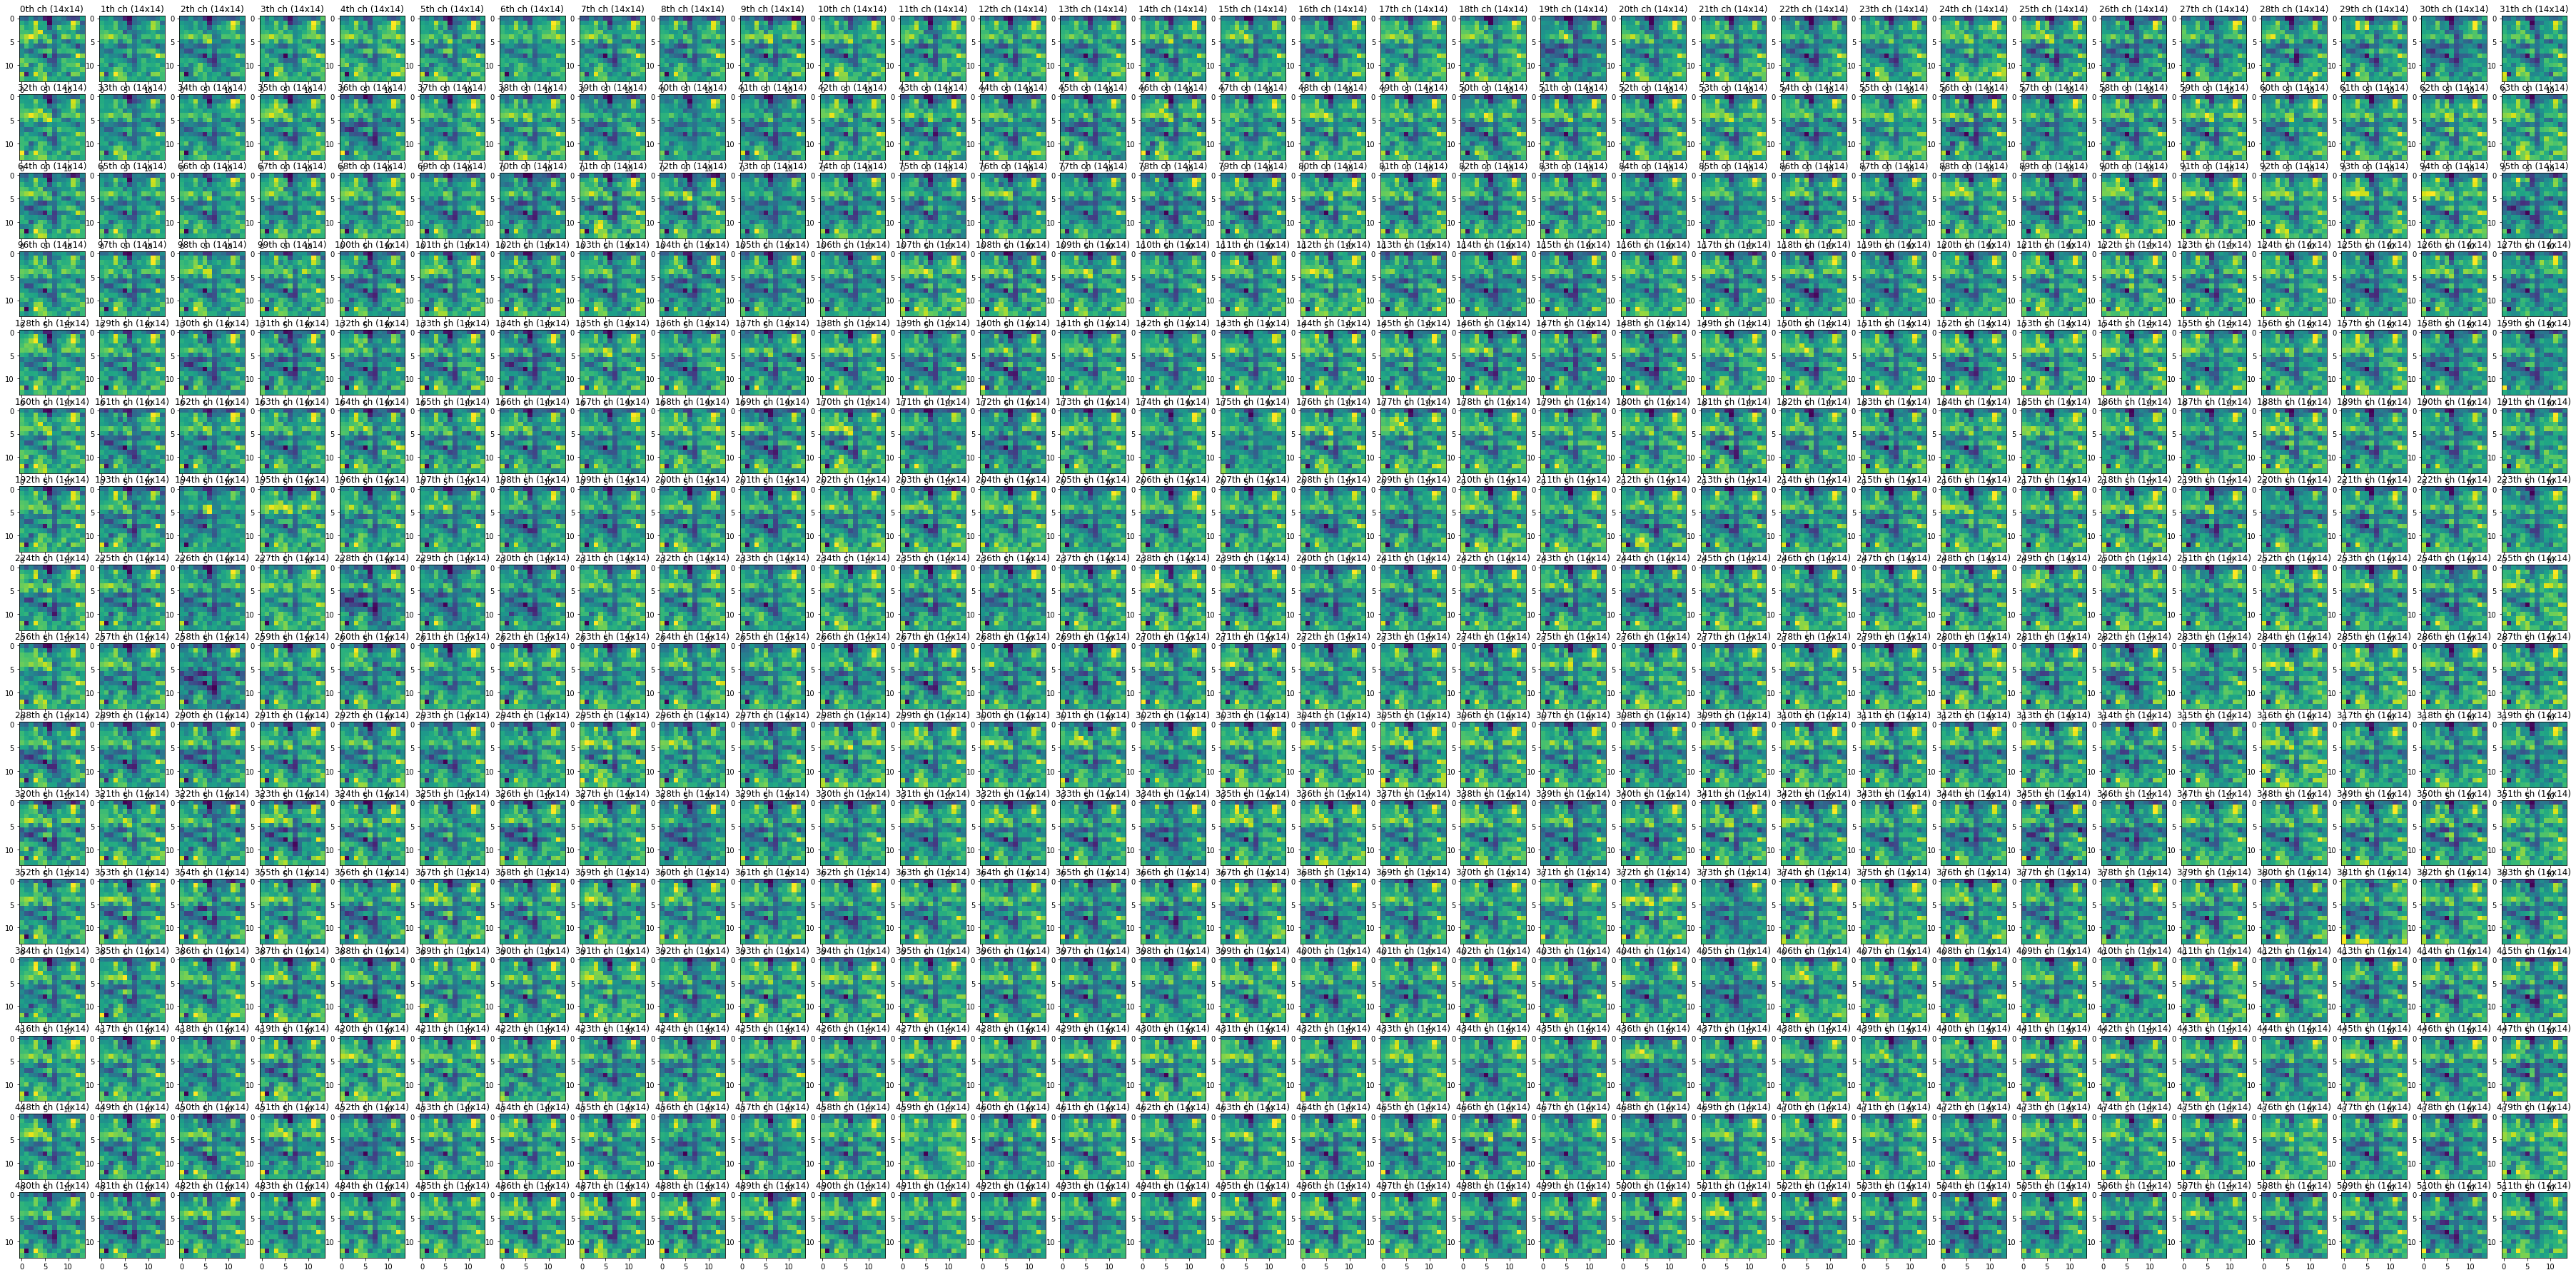

In [20]:
# f4f을 통과한 결과  epoch 1
%matplotlib inline
feature_print(first_feature[0][0].cpu().detach().numpy())

epoch 9
test with 'after pooling 4 feature'


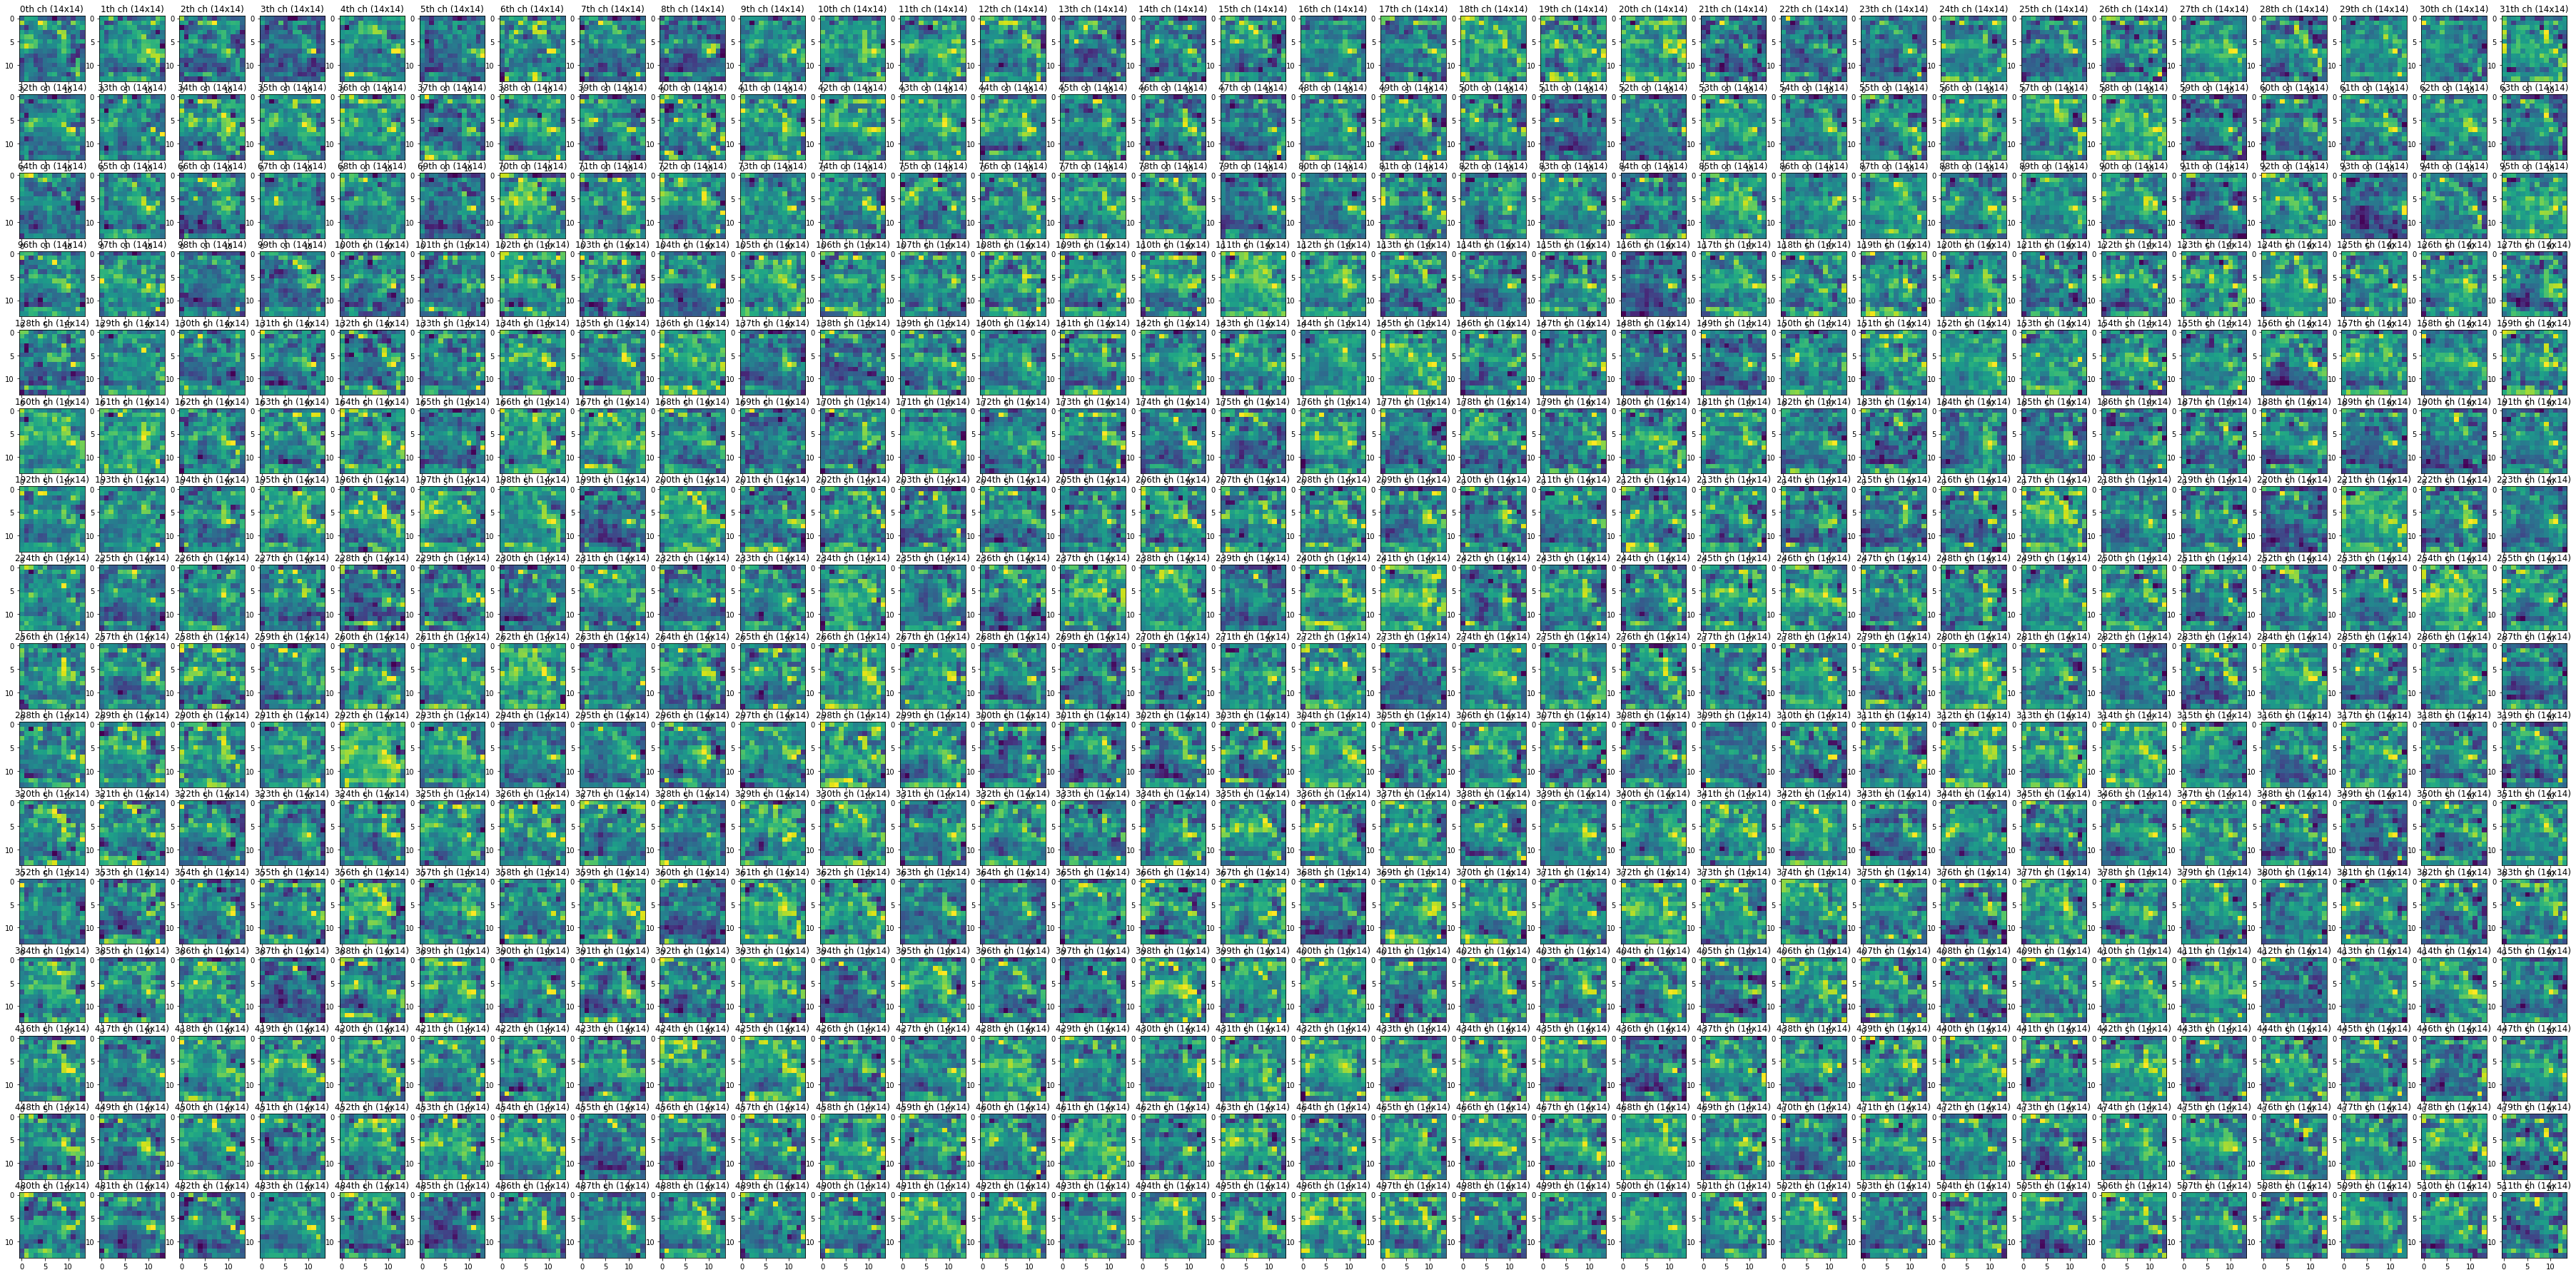

In [21]:
# f4f을 통과한 결과  epoch 9
print("epoch 9")
feature_print(first_feature[0][9].cpu().detach().numpy())

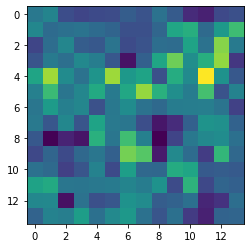

In [22]:
# 14x14 의 feature 모두 합한 결과
tmp = first_feature[0][6][0]
for i in range(1,512):
    tmp += first_feature[0][6][i]
%matplotlib inline
plt.imshow(tmp.cpu().detach())


original


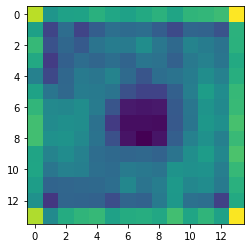

In [23]:
# 14x14 의 feature 모두 합한 결과
print("original")
tmp1 = original_out[0][6][0]
for i in range(1,512):
    tmp1 += original_out[0][6][i]
%matplotlib inline
plt.imshow(tmp1.cpu().detach())

epoch 6
test with 'after pooling 4 feature'


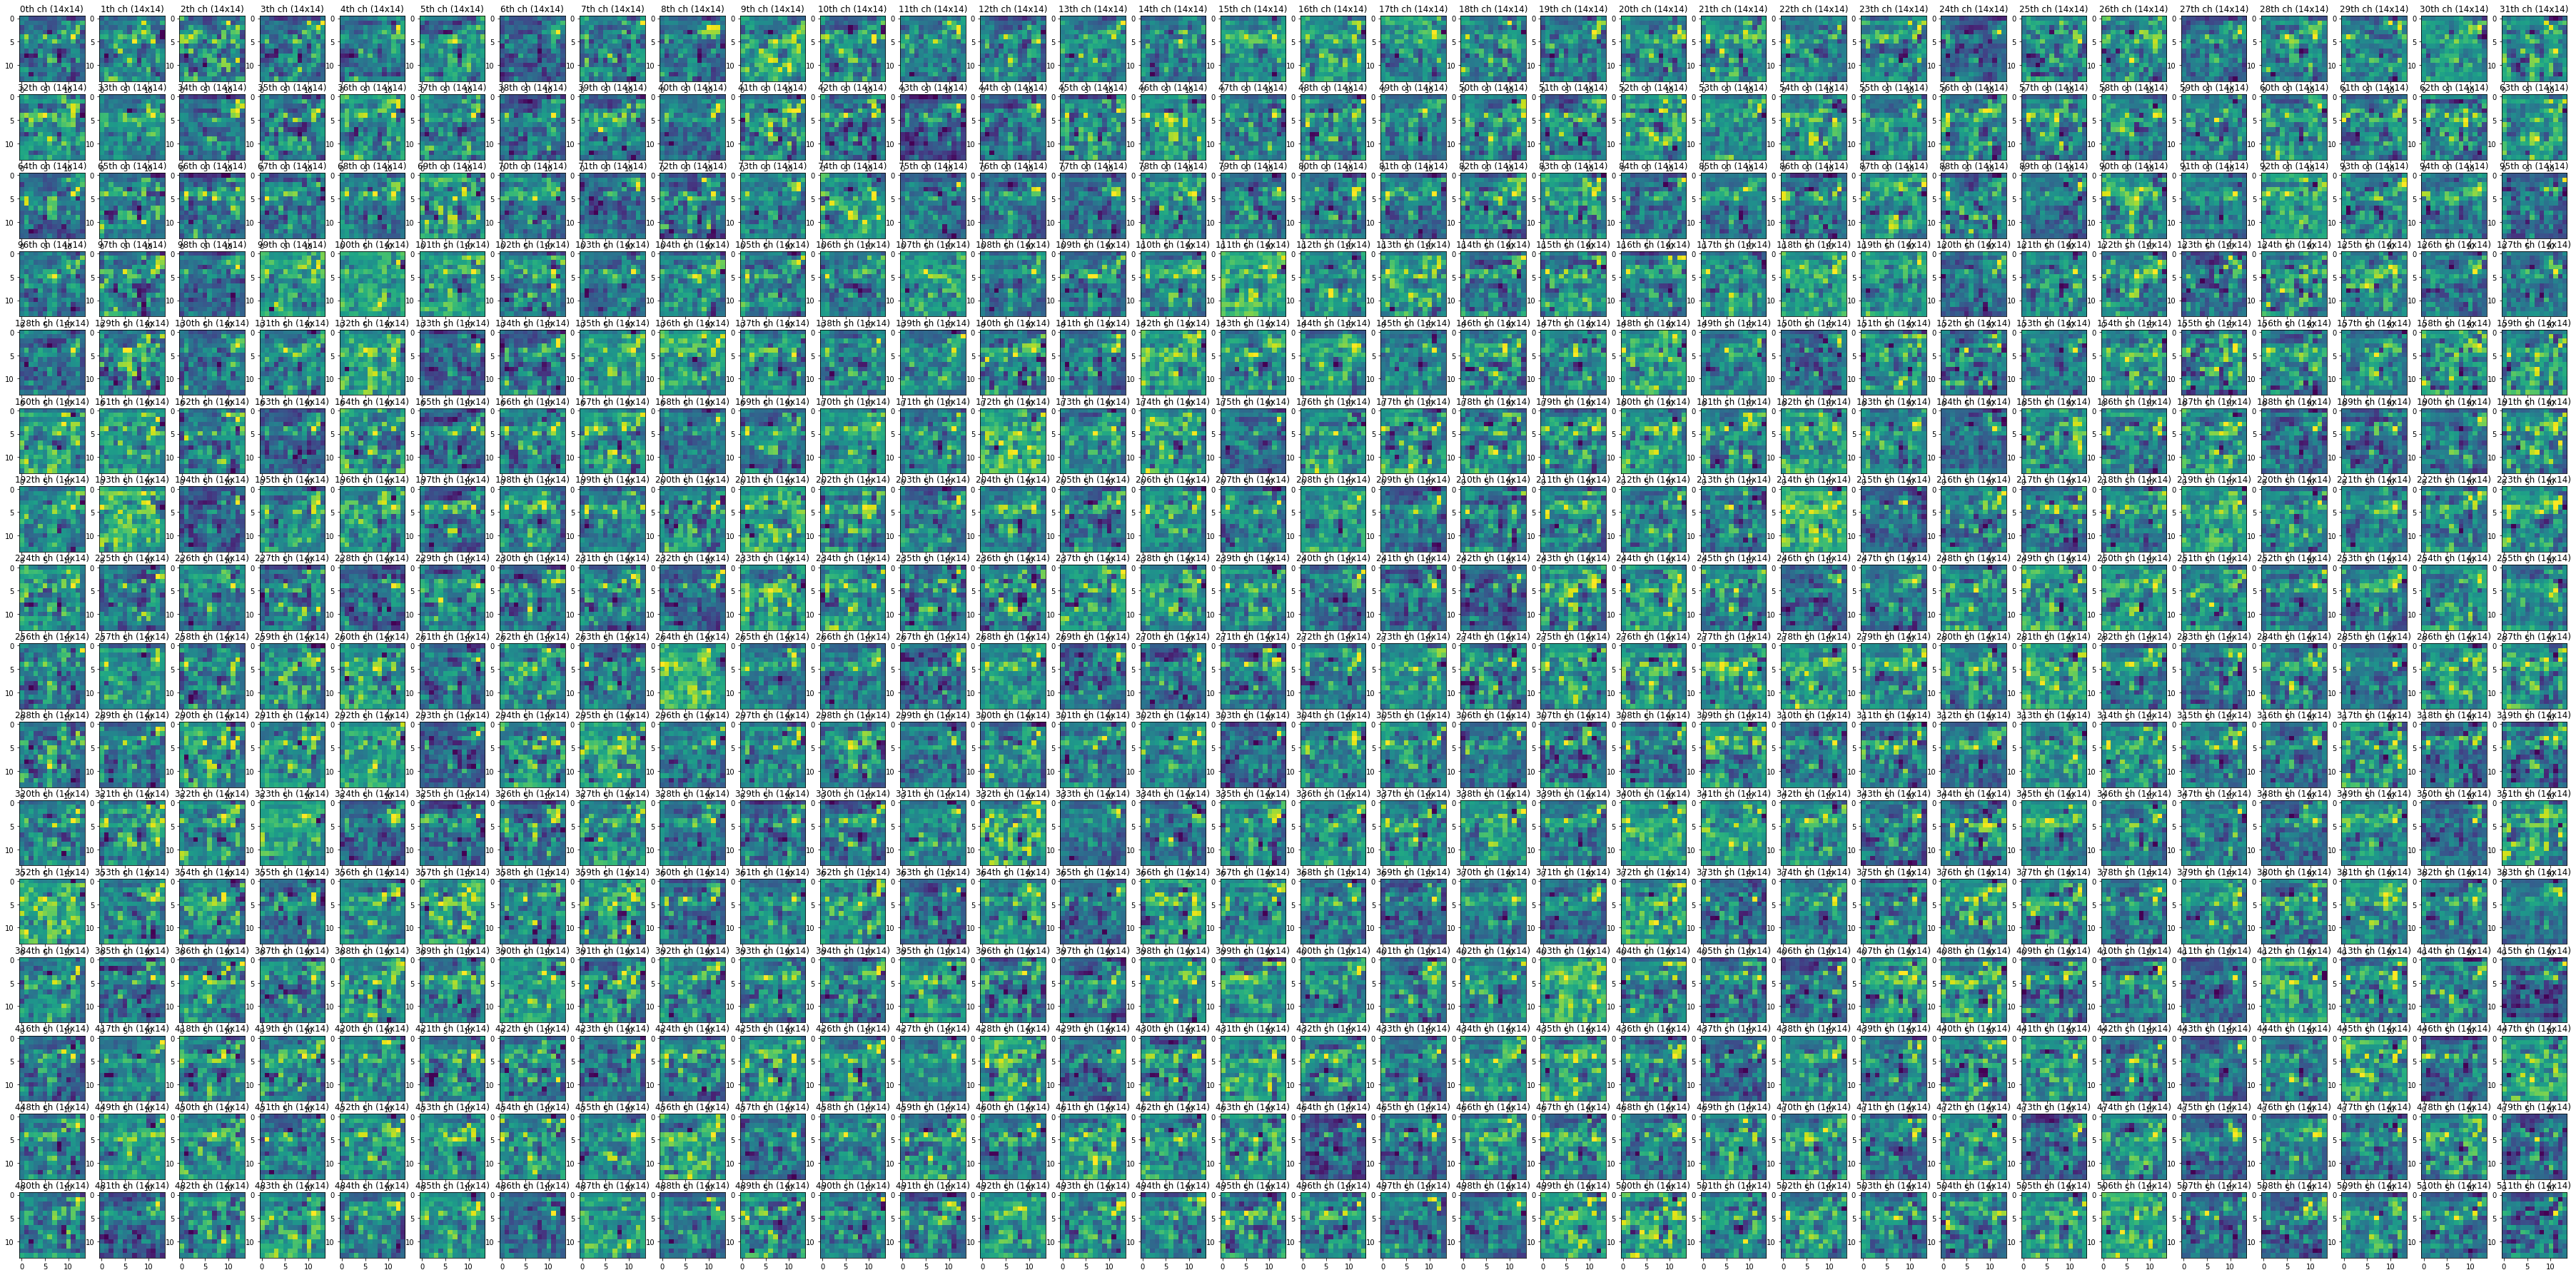

In [24]:
# f4f을 통과한 결과  epoch 6
print("epoch 6")
feature_print(first_feature[0][6].cpu().detach().numpy())